# Spis treści

1. [Problematyka](#problematyka)
2. [Charakterystyka danych]()
    1. [Rozkład liczebności tweetów i tagów w tekście](#rozklad_1)
    2. [Rozkład słów w tekście](#rozklad_2)
    3. [Rozkłady emotikonek w tekście](#rozklad_3)
    4. [Rozkład najczęściej występujących słów w tekście](#rozklad_4)
    5. [Wnioski z analizy danych](#wnioski_1)
3. [Uczenie algorytmów](#uczenie_algorytmow)
    1. [Przygotowanie danych](#przygotowanie_danych)
    2. [Uczenie i ocena modeli](#uczenie_ocena_modeli)
        1. [Baseline](#baseline)
        2. [Naive Bayes](#naive_bayes)
        3. [Support Vector Machines](#svm)
        4. [PolBERT](#polbert)
    3. [Porównanie wyników](#porownanie_wynikow)
    4. [Podsumowanie budowy modeli](#podsumowanie_budowy_modeli)
4. [Potencjalne dalsze kroki](#dalsze_kroki)
5. [Kolejny skrypt](#kolejny_skrypt)
        


---
---
<a id="problematyka"></a>
# Problematyka

Konkurs PolEval jest konkursem dla szeroko pojętej społeczności data scientist, w którym zadania dotyczą aspektów związanych z przetwarzaniem języka naturalnego. Celem konkursu jest zarówno dogłębniejsze zrozumienie problemów w przetwarzaniu języka naturalnego jak i opracowanie nowych metod dla języka polskiego, które mogą je rozwiązać. Jednym z takich zadań jest wykrywanie mowy nienawiści ([zadanie 6.2](http://2019.poleval.pl/index.php/tasks/task6)). Biorąc pod uwagę rozwój technologiczny obserwowany na codzień oraz fakt, że media społecznościowe stają się coraz ważniejszym elementem naszego życia, problem podjęty w tym zadaniu jest niezwykle istotny, bowiem na codzień każdy z użytkowników internetu spotyka się w mniejszym lub większym stopniu z mową nienawiści, która w zależności od odporności psychicznej człowieka może doprowadzić do różnych problemów natury psychicznej. 

W przypadku zadania z PolEval2019, mamy do czynienia z treściami tweetów w języku polskim, które zostały zaklasyfikowane w 3 kategorie:

1. `non-harmful` - tweety o treści nieszkodliwej;
2. `cyberbulling` - tweety charakteryzujące się mową nienawiści, które zostały skierowane wobec osób prywatnych;
3. `hate-speech` - tweety charakteryzujące się mową nienawiści, które zostały skierowane wobec osób publicznych, instytucji czy grup społecznych.

Celem jest zbudowanie możliwe jak najlepszego rozwiązania kategoryzującego tweety - w tym celu dysponujemy dwoma zbiorami: uczącym oraz testowym.

<a id="charakterystyka_danych"></a>
# Charakterystyka danych

W pierwszym etapie skupię sie na analizie zbiorów tweetów, w ramach której chce poznać strukture zbioru:

1. Jego liczność, 
2. Reprezentatywność poszczególnych kategorii,
3. "Właściwości" tekstów, na których będziemy pracować.

Sformułowane wnioski na podstawie tej analizy stanowić będą podstawę do kolejnych kroków, w których przygotowany zostanie odpowiedni proces przekształcenia danych oraz zaproponowane zostaną pierwsze algorytmy kategoryzujące tweety.

In [3]:
import os
import re
from collections import Counter
import random

import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.utils.validation import check_is_fitted
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from preprocessing import (
    read_texts_and_tags,
    merge_texts,
    tokenize_texts,
    search_non_ascii,
    search_text_with_word,
    WordCaser,
    PolishLetterReplacer,
    PunctuationRemover,
    StopWordsRemover,
    NonAsciiCharactersRemover,
    CurrencyRemover,
    UnitsRemover,
    NumberReplacer,
    WhitespaceRemover,
    NonAsciiCharacterWhitespaceSurrounder,
    PolBERTFeatureConstructor
)

from visualization import (
    plot_tags_distribution,
    plot_text_distribution,
    plot_non_ascii_distribution,
    calc_top_words_distribution
)

from validation import (
    show_top_n_words_naive_bayes,
    show_classification_report,
    check_inference_time
)

from IPython.core.display import HTML

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: center;
    align-items: center;
}
</style>
""")

SEED = 2021

In [4]:
path_data_folder = os.path.join(os.getcwd(), 'data')

texts_train, tags_train = read_texts_and_tags(path_data_folder, 'train')
texts_test, tags_test = read_texts_and_tags(path_data_folder, 'test')

<a id="rozklad_1"></a>
## Rozkład liczebności tweetów i tagów w tekście

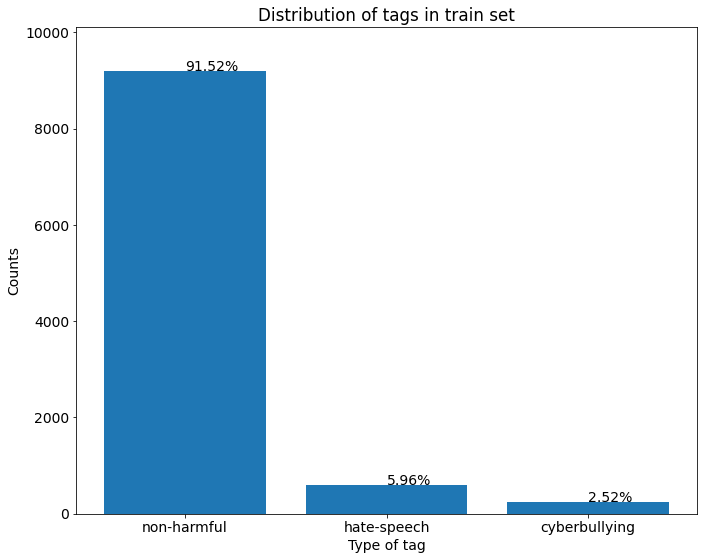

In [3]:
plot_tags_distribution(tags_train, title='Distribution of tags in train set')

In [4]:
print(f'Train set counts: {texts_train.shape[0]}')
print(f'Test set counts: {texts_test.shape[0]}')

Train set counts: 10041
Test set counts: 1000


Dysponujemy dwoma zbiorami:

1. Zbiorem uczącym, dłużącym do nauki algorytmów, liczącym 10041 tweetów oraz
2. Zbiorem testowym, na którym dokonana zostanie ostateczna ewaluacja algorytmów, liczącym 1000 tweetów.

Biorąc pod uwagę [średnią liczbę tweetów na sekundę wynoszącą 6000 w 2020 roku](https://www.dsayce.com/social-media/tweets-day/), dysponujemy niewielkim ułamkiem tweetów jakie możemy znaleźć w sieci. 

Dodatkowo analizując rozkłady kategorii w zbiorze uczącym dostrzegamy, że mamy problem z niedoreprezentatywnością kategorii identyfikujących mowe nienawiści - jest to tylko około 6% zbioru dla kategorii *hate-speech* oraz około 2,5% zbioru dla kategorii *cyberbullying*. 

Ze względu na tak dużą niedoreprezentatywnośći, najprawdopodobniej będziemy mieli duże problemy z nauczeniem algorytmów w identyfikacji tych dwóch kluczowych, z punktu widzenia podjętej problematyki, kategorii.  

*Powyższy wykres oraz dalsze analizy skupiać się będą na analizie tylko i wyłącznie zbioru uczącego. Nie "zaglądamy" do zbioru testowego, aby nie dopuścić do utworzenia czegoś w rodzaju "mentalnego obciążenia" polegającego na podejmowaniu decyzji, które podświadomie kierować będą Nas w celu "dopasowania się do zbioru testowego".*

<a id="rozklad_2"></a>
## Rozkład słów w tekście

W kolejnym etapie, przyjrzyjmy się rozkładowi słów występujących w tekście jeszcze przed jego obróbką.

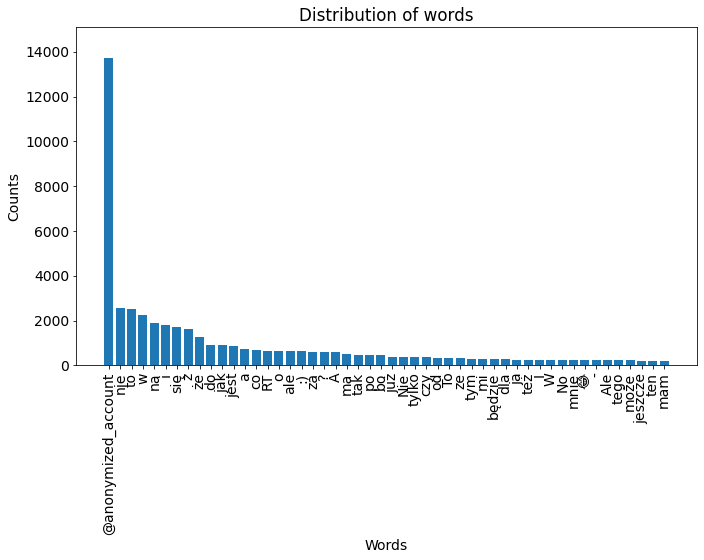

In [5]:
n_top_words = 50
plot_text_distribution(texts_train, n_top_words)

Tekst nie jest jeszcze w żaden sposób obrobiony - na ten moment wykres przedstawia rozkład słów w "surowym" tekście.

Wnioski płynące z powyższego wykresu:

1. Tak jak w przypadku wszystkich problemów dotyczących przetwarzania jezyka naturalnego, przy badaniu rozkładu słów w surowym tekście spodziewane jest by otrzymać rozkład składający się niemalże z samym stop-wordsów, tzn. wyrazów i wyrażeń, które uzupełniają tekst oraz nadają mu znaczenia, ale samodzielnie nie przekazują głębszej myśli, sensu lub konkretnych informacji np. a, co, ma, po, też itd. - oznacza to, że niezbędnym w procesie przygotowania danych będzie ich usunięcie.
2. Na pierwszym miejscu występuję słowo "@anonymized_account", które zgodnie z opisem zadania oznacza wynik procesu anonimizacji - wszelkie wskazania wprost, które jednoznacznie mogą zidentyfikować osobę publikującą tweety są anonimizowane. Zatem te słowo występujące w danych może zostać usunięte bez obaw o utratę cennych informacji - wręcz przeciwnie, słowo "@anonymized_account" wprowadza tylko szum.
3. Wśród dalszych słów występuje również "RT", które nie jest słowem polskim, a skróceniem wyrażeń "Replying to", które powstaje w sytuacji odpowiedzi na któregoś z tweetów. Słowo "RT", podobnie jak słowo "@anonymized_account" wprowdza szum i powinno zostać usunięte.
4. Wśród słów dostrzegamy również emotikonki w dwóch postaciach - tekstowych np. ":)" oraz graficznych np. "😀". Punkt ten dokładniej omówimy w kolejnych etapach.

<a id="rozklad_3"></a>
## Rozkłady emotikonek w tekście

Emotikonki zawarte w tekście mogą dostarczyć nam precyzyjniejszej informacji o charakterze tweeta, bowiem są one często reprezentantem naszych emocji jakie towarzyszą Nam podczas tweetowania. Jednakże są one zarazem wieloznaczne - uśmiech może reprezentować radość lub też wyśmiewanie się, szydzenie. 

Przyjrzyjmy się dokładniej rozkładom emotikonek w tekście.

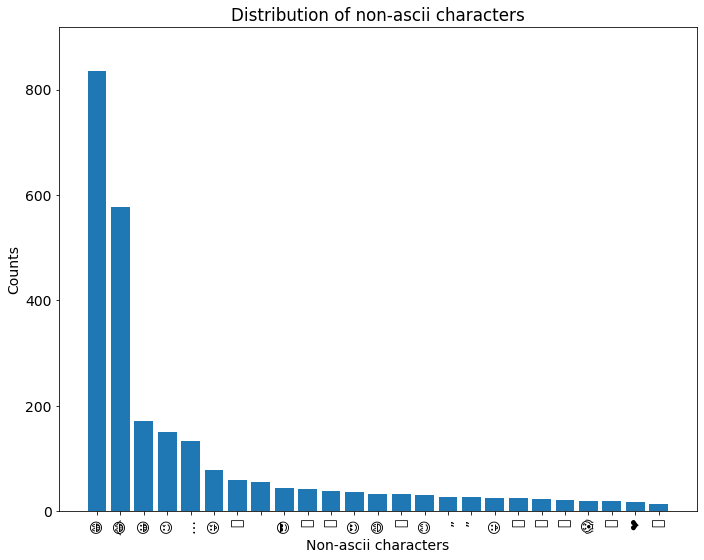

In [6]:
plot_non_ascii_distribution(
    texts_train,
    n_top_words=25,
    xlabel='Non-ascii characters',
    title='Distribution of non-ascii characters'
)

In [7]:
texts_non_ascii = search_non_ascii(texts_train)
texts_non_ascii = texts_non_ascii[texts_non_ascii != '']
n_non_ascii = texts_non_ascii.shape[0]
dist_non_ascii = n_non_ascii/texts_train.shape[0]
print(f'Number of tweets with atleast one emote {n_non_ascii} = {dist_non_ascii*100:.2f}%')

Number of tweets with atleast one emote 1562 = 15.56%


Dominującą emotikonką w tekście jest emotikonka reprezentująca uśmiech z zamkniętymi oczami 😁, następnie mamy uśmiech z łzami w oczach 😂, zwykły uśmieszek 😀, puszczenie oczka 😉, czy wystawienie języka 😜.

*Niestety część z nich nie jest możliwa do wyrenderowania przez pakiet matplotlib, dlatego obserwujemy kwadraciki*

Co to dla Nas oznacza? Mamy doczynienia raczej z "wesołymi" emotikonkami. "Wesołymi" na pierwszy rzut oka, bowiem to wszystko zależy od tego jaki mamy dobór słów, który szerzej mógłby Nam powiedzieć, czy emotikonka przedstawia faktycznie radość, czy może szydzenie, które wchodzić może w mowe nienawiści.

Liczebności emotikonek wskazują, że nie są one rzadkie - 15,56% tweetów posiada conajmniej jedną emotikonkę.

Sprawdźmy zatem jak wygląda to w poszczególnych kategoriach.

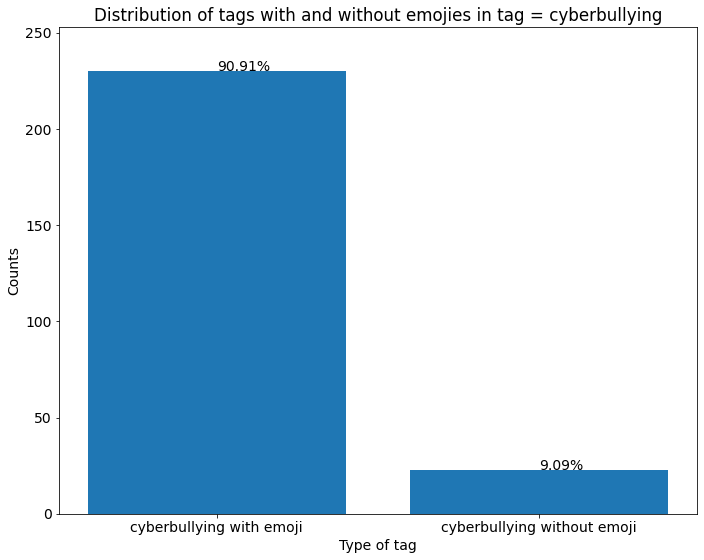

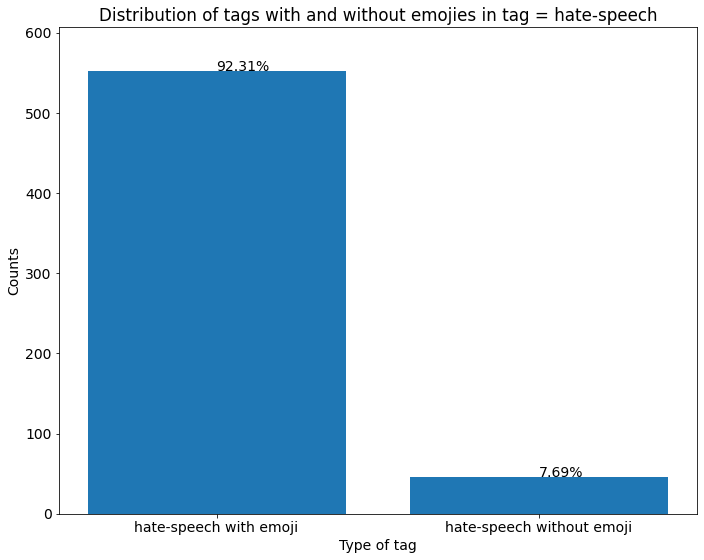

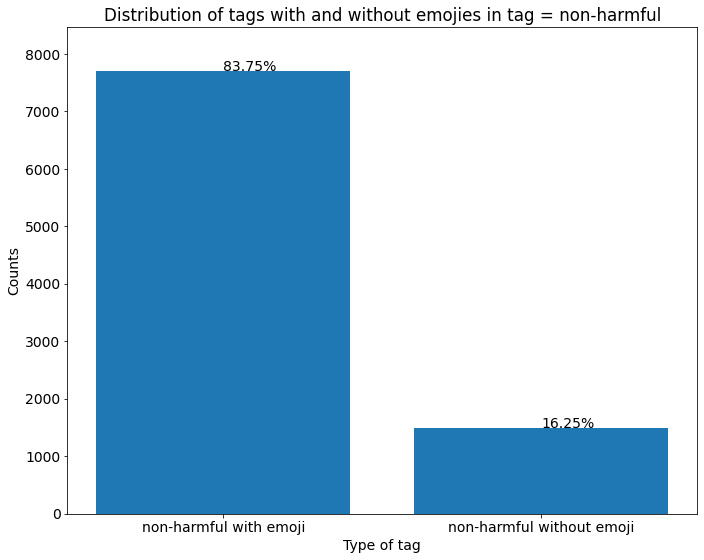

In [8]:
for tag in np.unique(tags_train):
    idx_tags = tags_train == tag

    texts = texts_train[idx_tags]
    texts = search_non_ascii(texts)

    tags = tags_train[idx_tags]
    tags = [f'{tag} without emoji' if text != '' else f'{tag} with emoji'
            for text, tag in zip(texts, tags)]
    title = f'Distribution of tags with and without emojies in tag = {tag}'
    plot_tags_distribution(tags, title=title)

Kategoria *non-harmful* charakteryzuje się tweetami o największym udziale tweetów z conajmniej jedną emotikonką, tj. 16,25%. W przypadku kategorii z mową nienawiści udział tych tweetów jest znacznie mniejszy i wynosi odpowiednio 7,69% dla kategorii *hate-speech* oraz 9,09% dla kategorii *cyberbulling*.

Biorąc pod uwagę najczęściej występujące emotikonki oraz rozkład tweetów z conajmniej jedną emotikonką spodziewać się można, że "wesołe" emotikonki mogą występować we wszystkich kategoriach, co spowoduje ich wieloznaczność, które istotnie może utrudnić identyfikację kategorii przez algorytmy. Przyjrzyjmy się zatem rozkładom emotikonek w poszczególnych kategoriach.

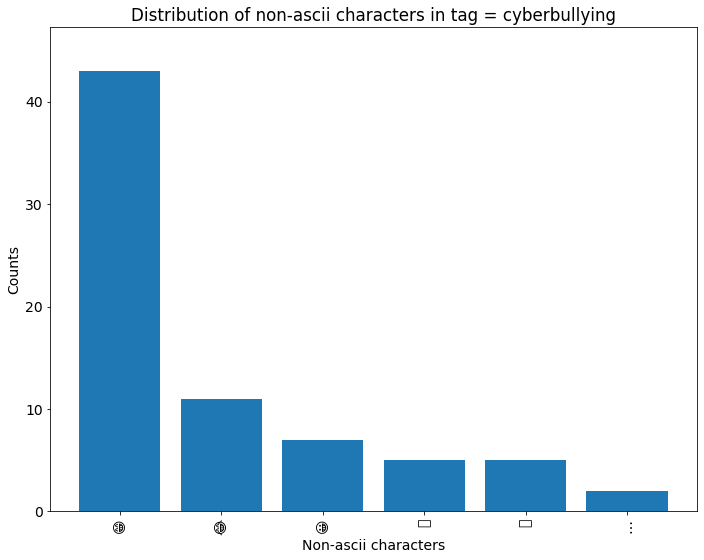

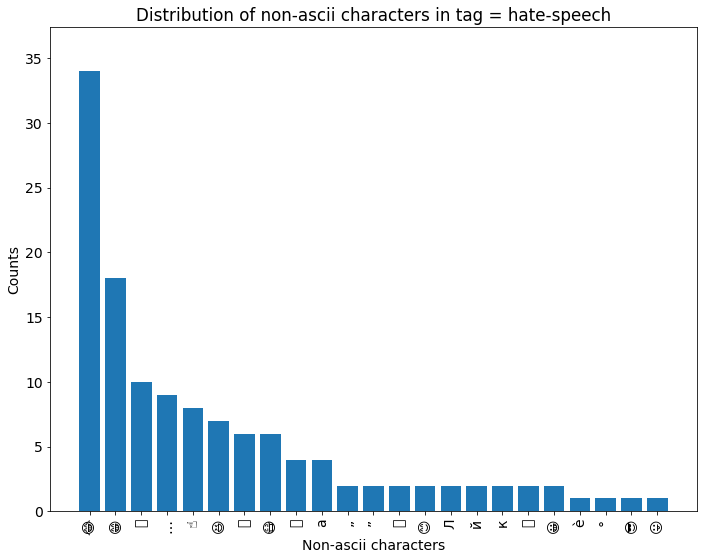

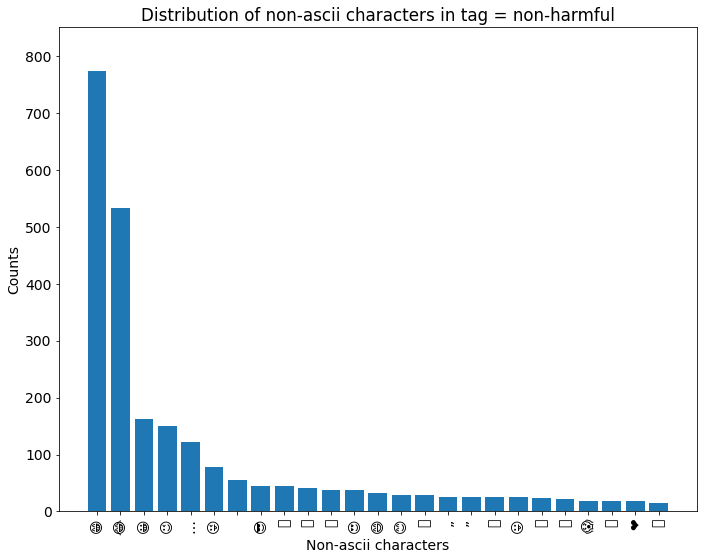

In [9]:
for tag in np.unique(tags_train):
    idx_tags = tags_train == tag
    plot_non_ascii_distribution(
        texts_train[idx_tags],
        n_top_words=25,
        xlabel='Non-ascii characters',
        title=f'Distribution of non-ascii characters in tag = {tag}'
    )

Analizując powyższe wykresy rozkładów emotikonek w poszczególnych kategoriach dostrzec można, że "wesołe" emotki są najczęściej występującymi emotkami w każdej z kategorii - potwierdza to obawy, jakie zostały wcześniej skonstruowane, tzn. będą one wieloznaczne. Innymi słowy, obecność "wesołych" emotek niekoniecznie może ułatwić kategoryzację tweetów.

Powyższe wnioski zostały zaprezentowane niżej w innej, zbiorczej formie, która porównuje najczęściej występujące emotki ze sobą.

In [10]:
texts_non_ascii = search_non_ascii(texts_train)
top_non_ascii_distribution = calc_top_words_distribution(
    texts_non_ascii,
    tags_train,
    split_point=''
)
top_non_ascii_distribution.style

,cyberbullying,hate-speech,non-harmful,rank
😁,1.000000,2.000000,1.000000,1.333333
😂,2.000000,1.000000,2.000000,1.666667
…,6.000000,4.000000,5.000000,5.000000
🤣,4.000000,3.000000,9.000000,5.333333
❗,nan,9.000000,nan,nan
👍,5.000000,nan,nan,nan
😎,nan,nan,8.000000,nan
😆,nan,6.000000,nan,nan
😜,nan,nan,6.000000,nan
😀,3.000000,nan,3.000000,nan


Powyższa tabela przedstawia:

1. W wierszach suma zbiorów emotek, które są najczęściej występujące w każdej z kategorii.
2. 3 kolumny - *cyberbulling*, *hate-speech* oraz *non-harmful* - które określają pozycję emotki w zbiorze, na podstawie częstości jej występowania.
3. Kolumna *rank* określająca średnią z rankingów, która służy do sortowania wyników tabel - od najczęstszych emotek do najrzadszych.

Wnioski z tabeli:

1. "Wesołe" emotki najczęściej występujące tzn. 😂, 😁, 😀 są zarazem emotkami najczęściej występującymi we wszystkich trzech kategoriach - oznacza to, że są wieloznaczne i ich obecność w tweetach najprawdopodobniej nie wpłynie istotnie na kategoryzację.
2. Istnieje emotka "…", którą nie jesteśmy w stanie zinterpretować.
3. Rozkład emotki 🤣, wskazuje, że częściej jest ona używana w ramach mowy nienawiści (zapewne do szydzenia) niż w tweetach normalnych.
4. Istnieją emotki, które są specyficzne dla danej kategorii i nie występują w żadnych innych kategoriach lub ich występowalność jest bardzo znikoma (*pamiętajmy, że powyższa tabelka zawiera 10 najczęściej występujących emotikonek w tekście*) np.:
    1. 👍 dla *cyberbulling*
    2. ☝ (środkowy palec), ❗ dla *hate-speech*
    3. 💪, 😉 dla *non-harmful*

<a id="rozklad_4"></a>
## Rozkład najczęściej występujących słów w tekście

Wykonajmy podobną analizę jak wyżej dla najczęściej występujących słów w tekście. 

Jednakże zanim go stworzymy, wcześniej dokonane obserwacje posłużą Nam do stworzenia pierwszego, potencjalnego pipeline do wyczyszczenia tekstu:

1. `WhitespaceRemover()` - Na wstępnie usuniemy białe znaki z początku oraz końca tweeta oraz zamienimy wielokrotne spacje pomiędzy poszczególnymi słowami na pojedynczą spację - ten zabieg jest istotny z racji tego, że proces tokenizacji najczęściej bazuje na podziale słów właśnie ze względu na spację. Obecność kilku spacji wygeneruje puste tokeny, które niepotrzebnie mogą komplikować dalsze etapy przetwarzania tekstu.
2. `WordCaser()` - Zamieniamy na małe litery.
3. `PolishLetterReplacer()` - Zamieniamy polskie litery diakrytyczne na ich odpowiedniki *nie-*diakrytyczne 
4. `StopWordsRemover()` - Usuwamy stop-words oraz dodatkowo zanonimizowane nazwy profili, tj. *anonymized_account* oraz oznaczenia systemowe odpowiedzi na tweety, tj. *RT*
5. `PunctuationRemover()` - Usuwamy interpunkcje - w tym momencie pozbywamy się również znaków ":", które są elementem emotikonek tekstowych, np. ":D". Akceptujemy to, bowiem zależy w tym kroku analizie podlegają tylko słowa i to z nich chcemy usunąć niepotrzebne znaki interpunkcyjne.
6. `NonAsciiCharactersRemover()` - Usuwamy litery i oznaczenia non-ascii - w tym przypadku emotikonki.
7. `CurrencyRemover()` - Usuwamy oznaczenia walut, np. zł czy znak dolara 
8. `UnitsRemover()` - Usuwamy jednostki miar, np. km, cm
9. `NumberReplacer()` - Zastępujemy lub usuwamy liczby - w tym przypadku usuwamy
10. `WhitespaceRemover()` - Na koniec ponownie czyścimy tekst z białych znaków

In [11]:
additional_stop_words = ['anonymized_account', 'rt']
additional_punctuation = ['\\\\n', '\\.', '/', '%', '\\\\', '@']
pipeline_steps = [
    ('whitespace_remover_1', WhitespaceRemover()),
    ('word_caser', WordCaser(case='lower')),
    ('polish_letter_replacer', PolishLetterReplacer()),
    ('stop_words_remover', StopWordsRemover(additional_stop_words)),
    ('punctuation_remover', PunctuationRemover(additional_punctuation)),
    ('non_ascii_characters_remover', NonAsciiCharactersRemover()),
    ('currency_remover', CurrencyRemover()),
    ('units_remover', UnitsRemover()),
    ('number_replacer', NumberReplacer(action='delete')),
    ('whitespace_remover_2', WhitespaceRemover())
]
cleaning_pipeline = Pipeline(pipeline_steps)
texts_train_cleaned = cleaning_pipeline.fit_transform(texts_train)
texts_train_cleaned = np.array(texts_train_cleaned)
n_top_words = 15
top_words_distribution = calc_top_words_distribution(
    texts_train_cleaned,
    tags_train,
    n_top_words
)
top_words_distribution

,cyberbullying,hate-speech,non-harmful,rank
chyba,12.0,7.0,1.0,6.666667
pewnie,NaN,NaN,6.0,NaN
masz,3.0,NaN,5.0,NaN
pis,NaN,3.0,NaN,NaN
troche,10.0,NaN,15.0,NaN
pisdzielstwo,NaN,6.0,NaN,NaN
dupe,11.0,NaN,NaN,NaN
mecz,NaN,NaN,14.0,NaN
meczu,NaN,NaN,8.0,NaN
polski,NaN,13.0,NaN,NaN


Analizując rozkłady najczęściej występujących słów w kategoriach dostrzec można, że jest tylko jedno słowo, które jest jednym z najliczniejszych słów we wszystkich 3 kategoriach (słowo: *chyba*) oraz jest kilka przypadków, które są wspólne dla dwóch kategorii (6 spośród 37 słów). Zatem zbiory słów najczęściej występujące w kategoriach są prawie w pełni rozłączne - jest to dobra informacja, bowiem te słowa będą najprawdopodobniej najbardziej istotne w kolejnych iteracjach, w których uczyć będziemy algorytmy. 

Dodatkowo, znaczenie słów charakterystycznych tylko i wyłącznie dla jednej kategorii jest również "unikatowy". Dostrzegalne jest to w szczególności gdy analizujemy słowa z kategorii *hate-speech* czy *cyberbulling* do kategorii *non-harmful* - kategorie z mowy nienawiści charakteryzują się wulgaryzmami, podczas gdy w normalnych tweetach możemy tego nie obserwować lub udział ich jest tak znikomy, że ich obecność może nie być istotna (*pamiętajmy, że powyższa tabelka zawiera 15 najczęściej występujących emotikonek w tekście*).

Słowa *p* oraz *d* wymagają dodatkowych wyjaśnień - są to emotki tekstowe, które zostały ucięte przez działanie obiektu `PunctuationRemover()`. Brakuje im średnika ":" przed literą.



<a id="wnioski_1"></a>
## Wnioski z analizy danych

1. Dysponujemy małym zbiorem danych (biorąc pod uwagę [średnią liczbę tweetów na sekundę wynoszącą 6000 w 2020 roku](https://www.dsayce.com/social-media/tweets-day/)) liczącym około 10000 przypadków na uczenie oraz 1000 na sprawdzenie. Dodatkowo, mamy niedoreprezentatywność tweetow z mową nienawiści - ich łączny udział stanowi około 9%. Przy tak mało licznym zbiorze i niedoreprezentatywności kategorii możemy spodziewać się trudności w uczeniu algorytmów.

2. Tweety zawierają w sobie również emotikonki, które mogą dostarczyć dodatkowej, istotnej informacji o charakterze tweeta. Z analiz ich częstości wynika jednak, że najczęściej występujące emotki (wesołe emotki) w całym zbiorze są również jednocześnie najczęściej występującymi emotkami wewnątrz kategorii - oznacza to, że są one wieloznaczne, przez co ich obecność w tweecie może nic nie zmienić. W prawdzie istnieją emotki, które są charakterystyczne dla danej kategorii, jednakże ich liczebności są na tyle małe, że wnioskowanie na ich podstawie może być obarczone dużym błędem. 

3. Z analizy rozkładów najczęściej występujących słów w tekście (zarówno przed jak i po wstępnej obróbce) wynika, że mamy dużo słów, które są charakterystyczne tylko i wyłącznie dla danej kategorii - nie tylko pod względem liczebności, ale również ich znaczenia. Istnieją również słowa, które należy uznać za dodatkowe *stop words* i ich się pozbyć.

<a id="uczenie_algorytmow"></a>
# Uczenie algorytmów

<a id="przygotowanie_danych"></a>
## Przygotowanie danych

Biorąc pod uwagę wnioski płynące ze wstępnej analizy danych z tweetera, pipeline przygotowujący danych będzie miał niniejszą strukturę:

1. `WordCaser()` - Zamieniamy na małe litery.
2. `PolishLetterReplacer()` - Zamieniamy polskie litery diakrytyczne na ich odpowiedniki *nie-*diakrytyczne 
3. `NonAsciiCharacterWhitespaceSurrounder()` - Decyduje się jednak na użycie emotikonek. Z analizy tweetów wynika, że bardzo często są one pisane jedna po drugiej. Niniejszy obiekt dodaje spacje pomiędzy nimi, tak aby tokenizacja odbyła się na nich prawidłowo (tokenizacja w dalszych etapach opiera się o podział ze względu na spację), tzn. każda emotka będzie pojedynczym tokenem.
4. `WhitespaceRemover()` - Usuwam nadmiarowe spacje, które powstały w wyniku kroku 3, czyli usuwamy z początku oraz końca textu oraz podwójne (lub więcej) spacje w środku textu.
4. `StopWordsRemover()` - Usuwamy stop-words oraz dodatkowo zanonimizowane nazwy profili, tj. *anonymized_account* oraz oznaczenia systemowe odpowiedzi na tweety, tj. *RT*
5. `PunctuationRemover()` - Usuwamy interpunkcje - w tym momencie pozbywamy się również znaków ":", które są elementem emotikonek tekstowych, np. ":D". **Założenie**: Uznaje tylko i wyłącznie emotikonki graficzne - spośród nich pozbywam się 😁, 😂, które występowały najczęściej w trzech kategoriach.
7. `CurrencyRemover()` - Usuwamy oznaczenia walut, np. zł czy znak dolara 
8. `UnitsRemover()` - Usuwamy jednostki miar, np. km, cm
9. `NumberReplacer()` - Zastępujemy lub usuwamy liczby - w tym przypadku usuwamy
10. `WhitespaceRemover()` - Na koniec ponownie czyścimy tekst z białych znaków, które powstały po poprzednich usunięciach.

Dodatkowo ze zbioru uczącego został wydzielony zbiór walidacyjny, stanowiący 30% zbioru uczącego.

In [6]:
texts_train_full = texts_train.copy()
tags_train_full = tags_train.copy()
texts_train, texts_val, tags_train, tags_val = train_test_split(
    texts_train_full,
    tags_train_full,
    test_size=0.3,
    random_state=SEED,
    stratify=tags_train
)

additional_stop_words = ['anonymized_account', 'rt']
additional_punctuation = ['\\\\n', '\\.', '/', '%', '\\\\', '@', '😁', '😂']
pipeline_steps = [
    ('word_caser', WordCaser(case='lower')),
    ('polish_letter_replacer', PolishLetterReplacer()),
    ('non_ascii_character_whitespace_sorrounder', NonAsciiCharacterWhitespaceSurrounder()),
    ('whitespace_remover_1', WhitespaceRemover()),
    ('stop_words_remover', StopWordsRemover(additional_stop_words)),
    ('punctuation_remover', PunctuationRemover(additional_punctuation)),
    ('currency_remover', CurrencyRemover()),
    ('units_remover', UnitsRemover()),
    ('number_replacer', NumberReplacer(action='delete')),
    ('whitespace_remover_2', WhitespaceRemover())
]
cleaning_pipeline = Pipeline(pipeline_steps)
texts_train_cleaned = cleaning_pipeline.fit_transform(texts_train)
texts_val_cleaned = cleaning_pipeline.transform(texts_val)
texts_test_cleaned = cleaning_pipeline.transform(texts_test)

Decyduję się na zamianę w ten sposób przygotowanego tekstu na macierze TF i/lub TF-IDF (w zależności od użytego algorytmu), która będzie wejściem do modeli, o poniższych parametrach:

1. `encoding='utf-8'` - aby przygotować macierz TF-IDF zarówno na bazie tekstu jak i emotikonek
2. `decode_error='strict'` - w sytuacji gdy pojawi sie znak nieobsługiwany przez utf-8, zwróci błąd
3. `strip_accents=None`, `lowercase=False`, `preprocessor=None`, `tokenizer=None` oraz `stop_words=None` - dlatego, że w poprzednim kroku wykonaliśmy już preprocessing
4. `analyzer='word'` oraz `token_pattern=r'(?u)\b\w\w\w+\b|[^\x00-\x7F]'` - pracujemy na słowach, które liczą conajmniej 3 litery (`(?u)\b\w\w\w+\b`) oraz na emotikonkach (`[^\x00-\x7F]`)
5. `ngram_range=(1, 1)` - ze względu na małą liczbę danych decyduje się na uni-gramy
6. `max_df=0.95` oraz `min_df=5` - nie chce bardzo rzadkich oraz zbyt częstych słów w macierzy TF-IDF

In [7]:
tfidf_params = {
    'encoding': 'utf-8',
    'decode_error': 'strict',
    'strip_accents': None,
    'lowercase': False,
    'preprocessor': None,
    'tokenizer': None,
    'analyzer': 'word',
    'stop_words': None,
    'token_pattern': r'(?u)\b\w\w\w+\b|[^\x00-\x7F]',
    'ngram_range': (1, 1),
    'max_df': 0.95,
    'min_df': 5
}

<a id="uczenie_ocena_modeli"></a>
## Uczenie i ocena modeli

Decyduję się na 4 modele:

1. Baseline, jako predykcja klasy najczęściej występującej w zbiorze danych
2. Naive Bayes
3. Support Vector Machines
4. PolBERT + Logistic Regression

Które zewaluluje pod kątem 4 wymiarów:

1. Jakości klasyfikacji - w tym celu posłuże się miarami accuracy, precision, recall, f1_score oraz f1 micro average która jest decydującą miarą w tym zadaniu, tzn. na jej podstawie wybierane jest najlepsze rozwiązanie,
2. Możliwośći interpretacji modelu,
3. Poziomie skomplikowania,
4. Czasu przetwarzania pojedynczej obserwacji.

<a id="baseline"></a>
### Baseline

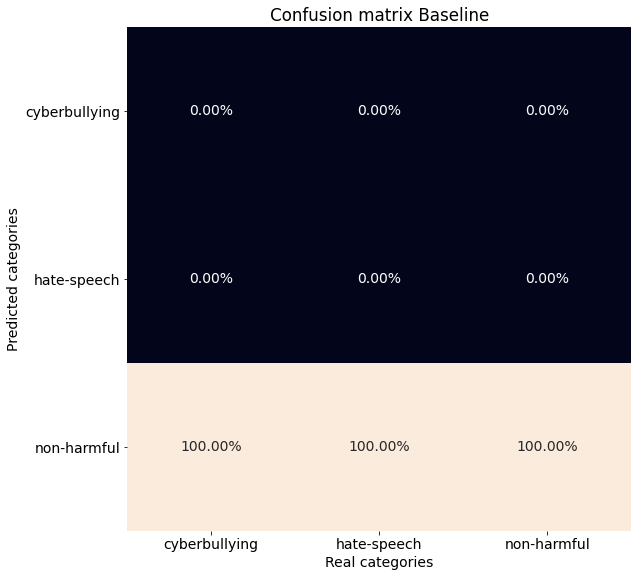

               precision    recall  f1-score   support

cyberbullying       0.00      0.00      0.00        53
  hate-speech       0.00      0.00      0.00       126
  non-harmful       0.92      1.00      0.96      1930

     accuracy                           0.92      2109
    macro avg       0.31      0.33      0.32      2109
 weighted avg       0.84      0.92      0.87      2109

F1 micro-average 0.9151256519677572


In [28]:
tags_val_pred = np.repeat('non-harmful', len(tags_val))
show_classification_report(tags_val, tags_val_pred, title='Confusion matrix Baseline')

Model Baseline jest modelem kompletnie naiwnym, który za każdym razem zwraca klasę *non-harmful*. Służy do stworzenia pewnego "minimum", poniżej którego wszelkie dalsze rozwiązania są po prostu nieakceptowalne.

Miarą F1 micro-average wynosi 0,9151 będzie ona wartościa referencyjną dla każdego następnego rozwiązania.

<a id="naive_bayes"></a>
### Naive Bayes

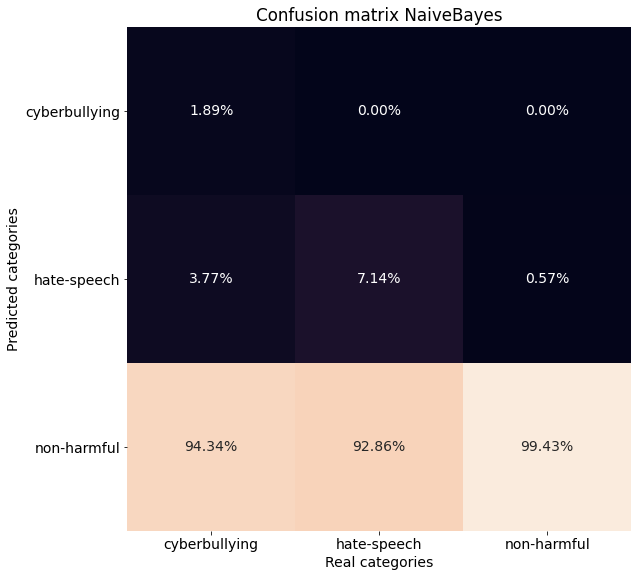

               precision    recall  f1-score   support

cyberbullying       1.00      0.02      0.04        53
  hate-speech       0.41      0.07      0.12       126
  non-harmful       0.92      0.99      0.96      1930

     accuracy                           0.91      2109
    macro avg       0.78      0.36      0.37      2109
 weighted avg       0.89      0.91      0.88      2109

F1 micro-average 0.914651493598862
Inference time: 0.006816 +- 0.005824 seconds


In [29]:
np.random.seed(SEED)
random.seed(SEED)

naive_bayes_params = {
    'alpha': 1.0
}

from sklearn.feature_extraction.text import CountVectorizer

nb_pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer(**tfidf_params)),
    ('naive_bayes', MultinomialNB(**naive_bayes_params)),
])

nb_pipeline.fit(texts_train_cleaned, tags_train)
tags_val_pred = nb_pipeline.predict(texts_val_cleaned)

show_classification_report(tags_val, tags_val_pred, title='Confusion matrix NaiveBayes')
check_inference_time(texts_train_full, cleaning_pipeline, nb_pipeline)

count_vectorizer = nb_pipeline['count_vectorizer']
classifier = nb_pipeline['naive_bayes']
top_words = show_top_n_words_naive_bayes(classifier, count_vectorizer)

Powyższy wykres przedstawia udział przewidzianych kategorii (oś Y) w prawdziwych kategoriach (oś X) - wartości w kolumnach sumują się do 100%. Wartości na przekątnych są tożsame z wartością *recall*.

Wartości *precision* oraz *recall* można interpretować w następujący sposób: Dla kategorii *hate-speech* precision (41%) oraz recall (11%) wskazują na to, że kiedy klasyfikator proponuje kategorię *hate-speech* to trafia on w 41% przypadków, ale niestety nie jest w stanie zidentyfikować wszystkich *hate-speech*, przez co pomija około 89% przypadków. Krótko mowiąc, jest precyzyjny w typowaniu *hate-speech*, ale nie wyłapie wszystkich.

Miara F1 micro-average jest połączeniem miar *precision* i *recall* - im większa wartość, tym lepiej - która dodatkowo bierze pod uwagę rozkład tagów w tekście.

Naive Bayes:

1. Jakości klasyfikacji - Naive Bayes w przeciwieństwie do Baseline kategoryzuje do 3, a nie do 1, kategorii, jednakże jego efektywność pozostawia wiele do życzenia, ponieważ wartość F1 micro-average wskazuje na to, że jest gorsza od Baseline o , co jest nie akceptowalne.
2. Możliwośći interpretacji modelu - Bazując na rozkładach prawdopodobieństw słów, których Naive Bayes się nauczył jesteśmy w stanie spojrzeć które słowa są "najważniejsze" w każdej z trzech kategorii. Pozwala to na zrozumienie którymi słowami najbardziej "kieruje się" w swoim działaniu przy kategoryzacji do danej kategorii. (tabelka niżej)

In [30]:
pd.DataFrame(top_words)

,cyberbullying,hate-speech,non-harmful
0,jestes,jestes,chyba
1,👍,🤣,😀
2,czym,jestescie,wiem
3,masz,kurwa,😉
4,polski,pajacu,https
5,prosze,chyba,masz
6,wiesz,kobieto,pewnie
7,bedziesz,debil,😜
8,chyba,debile,meczu
9,dupe,macie,wisla


3. Poziom skomplikowania - Algorytm Naive Bayesa jest algorytmem prostym - wykorzystuje on częstości słów do skonstruwoania ich rozkładów prawdopodobieństw, które następnie używane są do przewidzenia kategorii na postawie słów w tekście.
4. Czasu przetwarzania pojedynczej obserwacji - Cały proces przygotowania tekstu do jego predykcji wynosi 0.006816 +- 0.005824 sekund, co uznaję za bardzo szybką inferencję.

<a id="svm"></a>
### Support Vector Machines

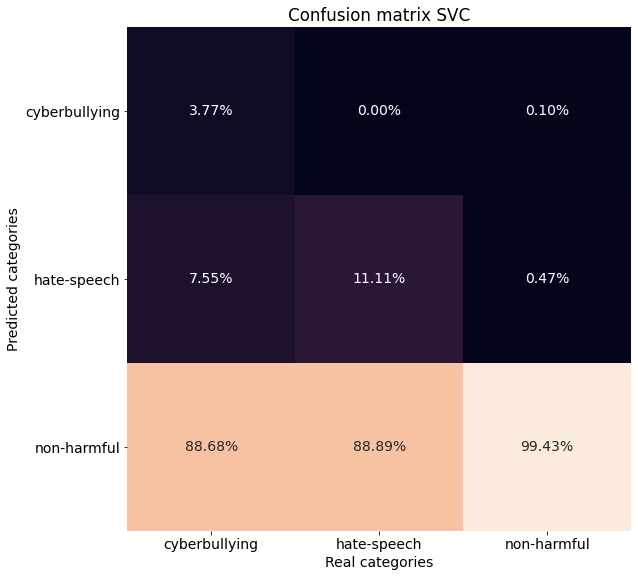

               precision    recall  f1-score   support

cyberbullying       0.50      0.04      0.07        53
  hate-speech       0.52      0.11      0.18       126
  non-harmful       0.92      0.99      0.96      1930

     accuracy                           0.92      2109
    macro avg       0.65      0.38      0.40      2109
 weighted avg       0.89      0.92      0.89      2109

F1 micro-average 0.9174964438122334
Inference time: 0.010239 +- 0.007766 seconds


In [33]:
np.random.seed(SEED)
random.seed(SEED)

svc_params = {
    'C': 1.0,
    'kernel': 'poly',
    'degree': 3
}

svc_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(**tfidf_params)),
    ('svc', SVC(**svc_params)),
])

svc_pipeline.fit(texts_train_cleaned, tags_train)
tags_val_pred = svc_pipeline.predict(texts_val_cleaned)

show_classification_report(tags_val, tags_val_pred, title='Confusion matrix SVC')
check_inference_time(texts_train_full, cleaning_pipeline, svc_pipeline)

Support Vector Classifier:

1. Jakości klasyfikacji - Support Vector Classifier osiąga wynik lepszy niż BaseLine, ale tylko o 0.0023 p. p.
2. Możliwośći interpretacji modelu - Dla kernela liniowego współczynniki jakich nauczył się SVM świadczyć mogą o ważności danego słowa ([przykładowa praca naukowa wykorzystująca współczynniki z liniowego SVMa do najsilniejszych wyboru zmiennych](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.70.9598&rep=rep1&type=pdf)), jednakże w przypadku innych kerneli taka interpretacja jest niemożliwa.
3. Poziom skomplikowania - SVM jest algorytmem skomplikowanym, który krótko mówiąc "przenosi" dane do większego wymiaru, w którym może istniec liniowa separowalność pomiędzy kategoriami.
4. Czasu przetwarzania pojedynczej obserwacji - Cały proces przygotowania tekstu do jego predykcji wynosi 0.010239 +- 0.007766 sekund, co uznaję za bardzo szybką inferencję.

<a id="polbert"></a>
### PolBERT

In [32]:
np.random.seed(SEED)
random.seed(SEED)

logistic_regression_params = {
    'penalty': 'l2',
    'C': 1.0,
    'random_state': SEED
}

polbert_pipeline = Pipeline([
    ('polbert_feature_constructor', PolBERTFeatureConstructor()),
    ('logistic_regression', LogisticRegression(**logistic_regression_params)),
])

polbert_pipeline.fit(texts_train_cleaned[:100], tags_train[:100])
tags_val_pred = polbert_pipeline.predict(texts_val_cleaned[:100])

check_inference_time(texts_train_full[:100], cleaning_pipeline, polbert_pipeline)

Some weights of the model checkpoint at dkleczek/bert-base-polish-uncased-v1 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/marcin/Marcin/WIEDZA/__zadania_rekrutacyjne/Sotrender/venv/lib/python3.7/site-packages/sklearn/lin

Inference time: 0.600284 +- 0.382061 seconds


Wykorzystanie PolBERTa jest następujące: wyciągamy z ostatniej ukrytej warstwy jej wagi, które stanowią zmienne dla regresji logistycznej.

Niestety zadanie nie jest możliwe do zrealizowania na moim komputerze (i niestety jest tak ze wszystkimi bilbiotekami do DL), ponieważ jest zbyt słaby aby stosować na nim bilbioteki do DL.

PolBERT:

1. Jakości klasyfikacji - Niestety nie możliwe jest zewalulowanie tego rozwiązania.
2. Możliwośći interpretacji modelu - Założenia działania BERTa są znane i opisane w pracach naukowych, jednakże mówiąc o "interpretacji" myślimy o otrzymaniu czegoś w postaci prostej struktury/wzoru, który jasno wskaże co jest najważniejsze w procesie kategoryzacji. Niestety w przypadku BERTa (czy ogólniej sieci neuronowych) jest to jeszcze niemożliwe.
3. Poziom skomplikowania - PolBERT jest algorytmem bardzo skomplikowanym (obecne SOTA).
4. Czasu przetwarzania pojedynczej obserwacji - Cały proces przygotowania tekstu do jego predykcji wynosi 0.600284 +- 0.382061 sekund - inferencja trwa długo.

<a id="porownanie_wynikow"></a>
## Porównanie wyników

|  | Baseline | Naive Bayes | Support Vector Machine | PolBERT |
|---|---|---|---|---|
| Jakość | 0.9151 | 0.9147 | 0.9175 | - |
| Interpretowalność | - | Możliwa | Trudna (tylko liniowy) | Niemożliwa |
| Poziom skomplikowania | - | Niski | Średni | Wysoki |
| Czas przetwarzania (w sekundach) | - | 0.006816 +- 0.005824 | 0.010239 +- 0.007766 | 0.600284 +- 0.382061 |

Naive Bayes został odrzucony ze względu na nieakceptowalny wynik F1 micro-average, pomimo możliwości jego interpretacji i najkrótszym czasie przetwarzania.

Jakość PolBERTa niestety nie była możliwa do zewaluowania ze względu na ograniczenia sprzętowe. Jednakże kwestią dyskusyjną pozostaje fakt, jak dobry musiałby być aby zaakceptować bardzo wysoki poziom skomplikowania, niemożliwą interpretację oraz długi czas inferencji. 

"Naturalnym" wyborem w tym przypadku staję się Support Vector Machines, który jest wyważonym rozwiązaniem pomiędzy  jakością a poziomem skomplikowania. Jego czas inferencji jest znacznie dłuższy niż Naive Bayesa (prawie dwukrotnie), ale oscyluje w granicach 0.01 sekund, co uznaję za zadowalający wynik.

W ostatnim kroku sprawdzimy jakość wybranego rozwiązania na zbiorze testowym

In [7]:
np.random.seed(SEED)
random.seed(SEED)

texts_train_full_clean = cleaning_pipeline.fit_transform(texts_train_full)
svc_pipeline.fit(texts_train_full_clean, tags_train_full)
tags_test_pred = svc_pipeline.predict(texts_test_cleaned)

tags_meanings = {
    'non-harmful': '0',
    'cyberbullying': '1',
    'hate-speech': '2'
}
tags_test_pred = [f'{tags_meanings[tag]}\n' for tag in tags_test_pred]
with open(os.path.join(path_data_folder, 'test_tags_pred.txt'), 'w') as file:
    file.writelines(tags_test_pred)
    
!perl data/evaluate2.pl data/test_tags_pred.txt

Micro-Average F-score = 86.90%
Macro-Average F-score = 42.61%


Porównując się do innych uczestników

| Miejsce | System name | Micro-Average F1 | Macro-Average F1 |
|---|:---:|:---:|:---:|
| 1 | model1-svm | 87.60 | 51.75 |
| 2 | ensamble spacy + tpot + BERT | 87.10 | 46.45 |
| **3** | **Marcin - zadanie rekrutacyjne** | **86.90** | **42.61** | 
| 4 | fasttext | 86.80 | 47.22 |
| 5 | model3-flair | 86.80 | 45.05 |
| 6 | SCWAD-CB | 83.70 | 49.47 |
| 7 | model2-gru | 78.80 | 49.15 |
| 8 | Task 6: Automatic cyberbullying detection (J.K.) | 70.40 | 37.59 |
| 9 | ensamble + fastai | 61.60 | 39.64 |

uzyskujemy wynik 86,90% co plasuje rozwiązanie na 3 miejscu.

<a id="podsumowanie_budowy_modeli"></a>
## Podsumowanie budowy modeli

Tak jak zostało to już podkreślone we wnioskach po wstępnej analizie danych, najprawdopodobniej nauka klasyfikatorow na tak małym zbiorze danych, charakteryzującym się niedoreprezentowaniem klas mowy nienawiści (*hate-speech* oraz *cyberbullying*), będzie trudna. Potwierdzeniem tego faktu są wyniki klasyfikatorów, które pod względem jakości są niewiele lepsze niż model naiwny, zwracający za każdym razem klase *non-harmful*. Dla podkreślenia trudności tego zadania, wyliczyłem wynik takiego modelu naiwnego na zbiorze testowym i wynosi on 86.60. Patrząc na tabelkę powyżej z wynikami, 4 z 9 rozwiązań są gorsze od modelu naiwnego, a najlepsze rozwiązanie (model1-svm) jest od niego lepsze o zaledwie 1 p. p., a moje zaledwie o 0.3 p. p.

Ostateczne wybrane rozwiązanie to model Support Vector Machines, który jest wyważonym rozwiązaniem pomiędzy  jakością a poziomem skomplikowania. W dodatku szybko przetwarza obserwacje ze średnim czasem inferencji 0.01 sekund.

<a id="dalsze_kroki"></a>
# Potencjalne dalsze kroki

Istnieją obszary, w których można by przeprowadzić więcej eksperymentów:

1. Problem niedoreprezentatywności można by rozwiązać na dwa sposoby: 
    1. Nadpróbkowanie (ang. *oversampling*) - wygenerowanie dodatkowych sztucznych obserwacji np. korzystając z SMOTE. Nigdy nie robiłem tego w temacie NLP, jedynie w modelach klasyfikacyjnych bazujących na danych finansowych, jednakże te rozwiązanie się tam nie sprawdzało.
    2. Niedopróbkowanie (ang. *undersampling*) - wybranie podzbioru textów tak aby "zwiększyć" udział klas niedoreprezentowanych. Osobiście poszedłbym w tym kierunku i zbadał czy może to poprawić wyniki.
    
2. Najlepszy model, który wygrał, też był SVMem. W prezentacji było zawarta informacja, że emotikonki zostały jednak usunięte ze zbioru, a ja je zawarłem. Warto byłoby sprawdzić hipotezę czy faktycznie poprawiają one klasyfikatory czy też nie. Ja w swojej pracy założyłem, że tak, ale warto byłoby to potwierdzić.

3. Do klasyfikatorów podana została cała macierz TF-IDF. Można by zastanowić się czy nie lepiej wybrać z niej pewien podzbiór "najlepszych słow". W prezentacji rozwiązania 2. (ensemble spacy + tpot + BERT) zostało pokazane, że TPOT w trakcie swojego przebiegu zaproponował najlepsze rozwiązanie, które w preprocessingu miało wybór 6% najlepszych zmiennych. W prawdzie nie dotyczyło to stricte macierzy TF-IDF (a chyba surowych danych? tego brak w prezentacji), ale uważam że warto byłoby to sprawdzić w naszym przypadku.

4. W swoim opracowaniu chciałem spróbować użyć PolBERTa, niestety możliwości sprzętowe nie pozwoliły. Na pewno w kolejnej iteracji przeniósłbym to rozwiązanie na np. google colab i tam zweryfikował hipotezę. Jednakże z prezentacji rozwiązań jasno wynika, że przy tym problemie najlepiej radzą sobie modele ML, a nie DL - z prostej przyczyny: bardzo mała ilość danych.

5. Przy budowie modeli ML zabrakło optymalizacji hiperparametrów np. z wykorzystaniem optuny. Jednakże przy tak mało licznych zbiorach danych i niedoreprezentatywności 2 z 3 klas uważam, że optymalizacja nie jest tutaj rozwiązaniem problemu a jedynie "doszlifowaniem wyników". Większy uzysk w tym przypadku uzyskamy albo z poradzeniem sobie z tak małą ilością danych (patrz punkt 1) lub lepszym przygotowaniem danych i potem utworzonych z nich zmiennych (patrz punkt 2 i 3). 

<a id="kolejny_skrypt"></a>
# Kolejny skrypt

Proszę o uruchomienie skryptu `2. train.ipynb`, który omawia zagadnienia CI/CD oraz działanie skryptu `train.py`.